# 1. Функция stitch_images: 
Это первый метод для склеивания двух изображений вместе.
   
# 2. Функция draw_matches: 
Эта функция используется для отображения соответствующих точек между двумя изображениями.
   
# 3. Функция warpImages: 
Эта функция отвечает за перспективное преобразование, чтобы два изображения могли правильно склеиваться вместе.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def stitch_images(img1, img2, MIN, ratio):
    # 统一图像大小Унификация размеров изображений
    height1 = int(img1.shape[0])
    width1 = int(img1.shape[1])
    dim = (width1, height1)
    img2 = cv.resize(img2, dim, interpolation=cv.INTER_AREA)

    # 创建SIFT特征点检测Создание обнаружения точек признаков SIFT
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # 使用OpenCV中的FLANN匹配算法进行特征匹配Выполнение сопоставления признаков с использованием алгоритма FLANN в OpenCV
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # 储存优质匹配点对Сохранение высококачественных пар сопоставленных точек
    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)

    # 计算单应性矩阵Расчет матрицы гомографии
    if len(good) > MIN:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

        # 透视变换Перспективное преобразование
        warpimg = cv.warpPerspective(img2, np.linalg.inv(M), (img1.shape[1] + img2.shape[1], img2.shape[0]))

        # 拼接图像Склеивание изображений
        direct = warpimg.copy()
        direct[0:img1.shape[0], 0:img1.shape[1]] = img1
        rows, cols = img1.shape[:2]

        # 找到重叠边界Найти границы перекрытия
        left = 0
        right = cols
        for col in range(0, cols):
            if img1[:, col].any() and warpimg[:, col].any():
                left = col
                break
        for col in range(cols - 1, 0, -1):
            if img1[:, col].any() and warpimg[:, col].any():
                right = col
                break

        #图像融合 Слияние изображений
        res = np.zeros([rows, cols, 3], np.uint8)
        for row in range(0, rows):
            for col in range(0, cols):
                if not img1[row, col].any():
                    res[row, col] = warpimg[row, col]
                elif not warpimg[row, col].any():
                    res[row, col] = img1[row, col]
                else:
                    srcimgLen = float(abs(col - left))
                    testimgLen = float(abs(col - right))
                    alpha = srcimgLen / (srcimgLen + testimgLen)
                    res[row, col] = np.clip(img1[row, col] * (1 - alpha) + warpimg[row, col] * alpha, 0, 255)

        warpimg[0:img1.shape[0], 0:img1.shape[1]] = res

        # 重新校准图像尺寸Перекалибровка размера изображения
        warpimg = cv.resize(warpimg, (img1.shape[1], img1.shape[0]), interpolation=cv.INTER_AREA)

        return warpimg
    
def draw_matches(img1, keypoints1, img2, keypoints2, matches):
  r1, c1 = img1.shape[:2]
  r2, c2 = img2.shape[:2]

  # Create a blank image with the size of the first image + second image
  output_img = np.zeros((max([r1, r2]), c1+c2, 3), dtype='uint8')
  output_img[:r1, :c1, :] = img1 #np.dstack([img1, img1, img1])
  output_img[:r2, c1:c1+c2, :] = img2 #np.dstack([img2, img2, img2])

  for match in matches:
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt

    # Draw circles on the keypoints
    cv.circle(output_img, (int(x1),int(y1)), 1, (0, 255, 255), 1)
    cv.circle(output_img, (int(x2)+c1,int(y2)), 1, (0, 255, 255), 1)

    # Connect the same keypoints
    cv.line(output_img, (int(x1),int(y1)), (int(x2)+c1,int(y2)), (0, 255, 255), 1)

  return output_img

def warpImages(img1, img2, H):
  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

  translation_dist = [-x_min, -y_min]

  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv.warpPerspective( img2, H_translation.dot(H), (x_max-x_min, y_max-y_min) )
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img


#Чтение изображений
path_img1 = r"D:\Projects\Pycharm_projects\CV\task3\building1\building1.jpg"
path_img2 = r"D:\Projects\Pycharm_projects\CV\task3\building1\building2.jpg"
path_img3 = r"D:\Projects\Pycharm_projects\CV\task3\building1\building3.jpg"
path_img4 = r"D:\Projects\Pycharm_projects\CV\task3\building1\building4.jpg"
path_img5 = r"D:\Projects\Pycharm_projects\CV\task3\building1\building5.jpg"

img1 = cv.imread(path_img1)
img2 = cv.imread(path_img2)
img3 = cv.imread(path_img3)
img4 = cv.imread(path_img4)
img5 = cv.imread(path_img5)

# Используя первый метод сшивания изображений (функция stitch_images), сшейте вместе рисунки 2 и 3 слева и рисунки 4 и 5

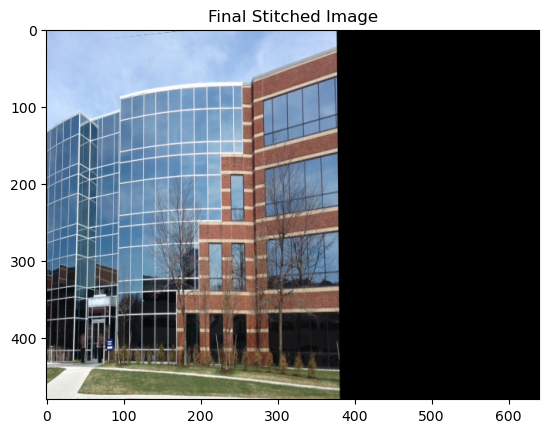

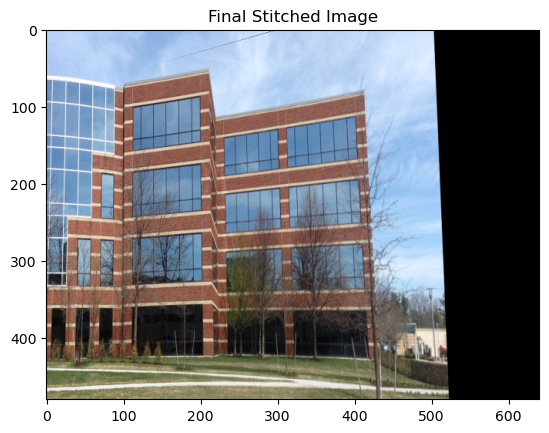

In [2]:
image23 = stitch_images(img2, img3, MIN=10, ratio=0.6)
#plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(image23, cv.COLOR_BGR2RGB))
plt.title('Final Stitched Image')
plt.show()

image45 = stitch_images(img4, img5, MIN=10, ratio=0.6)
#plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(image45, cv.COLOR_BGR2RGB))
plt.title('Final Stitched Image')
plt.show()

# Выполните преобразование перспективы для этих двух изображений

Selected points:
Point 1: [0. 2.]
Point 2: [379.   2.]
Point 3: [383. 476.]
Point 4: [  3. 478.]
Homography Matrix:
[[ 2.62749573e+00 -1.65598470e-02  3.31196940e-02]
 [ 8.40512141e-17  1.05325052e+00 -2.10650105e+00]
 [-1.10568138e-05  5.70641915e-06  1.00000000e+00]]


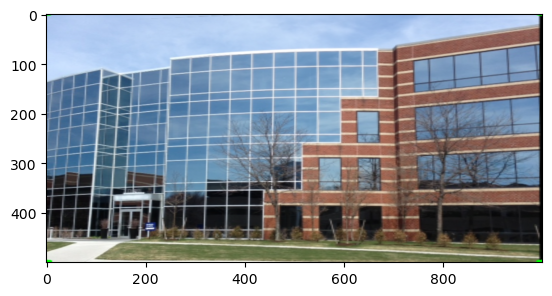

In [3]:
img=image23.copy()

points = []
def select_points(event, x, y, flags, param):
    global points
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x, y])
        cv.circle(img, (x, y), 5, (0, 255, 0), -1)
        cv.imshow('image', img)

cv.namedWindow('image')
cv.setMouseCallback('image', select_points)
cv.imshow('image', img)
cv.waitKey(0)
cv.destroyAllWindows()

if len(points) != 4:
    raise ValueError("You must select exactly 4 points.")
points = np.array(points, dtype=np.float32)

print("Selected points:")
for i, point in enumerate(points):
    print(f"Point {i+1}: {point}")

width, height =1000,500
dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

M, _ = cv.findHomography(points, dst_points)
print("Homography Matrix:")
print(M)

result1 = cv.warpPerspective(img, M, (width, height))
plt.imshow(cv.cvtColor(result1,cv.COLOR_BGR2RGB))
plt.show()

Selected points:
Point 1: [1. 1.]
Point 2: [504.   3.]
Point 3: [525. 478.]
Point 4: [  4. 478.]
Homography Matrix:
[[ 1.97991765e+00 -1.24523123e-02 -1.96746534e+00]
 [-4.31816871e-03  1.08601943e+00 -1.08170126e+00]
 [-8.63633742e-06  7.54627062e-05  1.00000000e+00]]


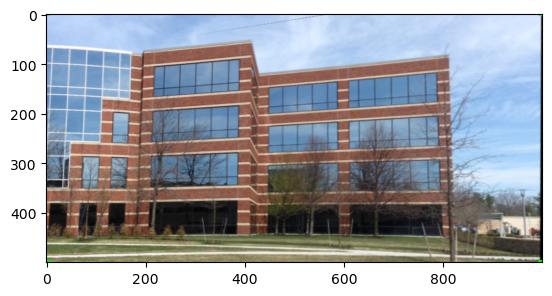

In [4]:
import cv2 as cv
import numpy as np

imgg=image45.copy()
points = []
def select_points(event, x, y, flags, param):
    global points
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x, y])
        cv.circle(imgg, (x, y), 5, (0, 255, 0), -1)
        cv.imshow('image', imgg)
cv.namedWindow('image')
cv.setMouseCallback('image', select_points)
cv.imshow('image', imgg)
cv.waitKey(0)
cv.destroyAllWindows()

if len(points) != 4:
    raise ValueError("You must select exactly 4 points.")
points = np.array(points, dtype=np.float32)

print("Selected points:")
for i, point in enumerate(points):
    print(f"Point {i+1}: {point}")

width, height =1000,500
dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

M, _ = cv.findHomography(points, dst_points)
print("Homography Matrix:")
print(M)

result2 = cv.warpPerspective(imgg, M, (width, height))
plt.imshow(cv.cvtColor(result2,cv.COLOR_BGR2RGB))
plt.show()

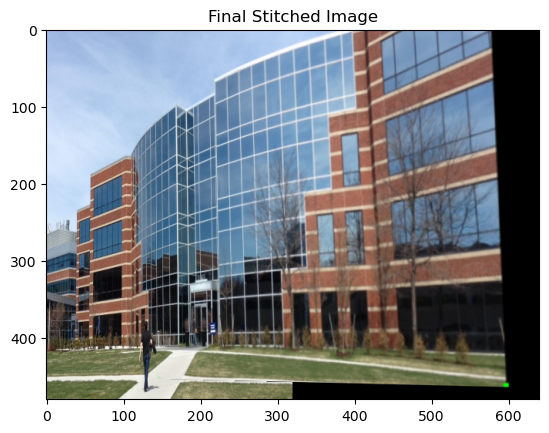

In [5]:
image123 = stitch_images(img1, result1, MIN=15, ratio=0.68)
#plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(image123, cv.COLOR_BGR2RGB))
plt.title('Final Stitched Image')
plt.show()

Selected points:
Point 1: [0. 2.]
Point 2: [581.   3.]
Point 3: [600. 464.]
Point 4: [  2. 476.]
Homography Matrix:
[[ 1.67543412e+00 -7.06934226e-03  1.41386845e-02]
 [-1.87063504e-03  1.08683896e+00 -2.17367791e+00]
 [-4.60783045e-05  6.38823627e-05  1.00000000e+00]]


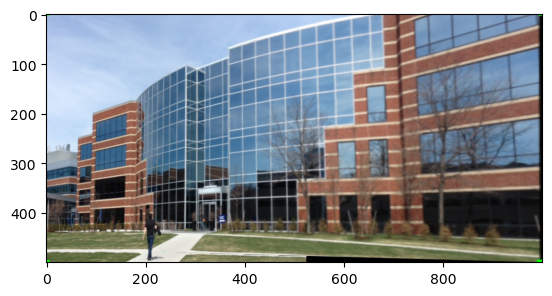

In [6]:
import cv2 as cv
import numpy as np

imggg=image123.copy()
points = []
def select_points(event, x, y, flags, param):
    global points
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x, y])
        cv.circle(imggg, (x, y), 5, (0, 255, 0), -1)
        cv.imshow('image', imggg)
cv.namedWindow('image')
cv.setMouseCallback('image', select_points)
cv.imshow('image', imggg)
cv.waitKey(0)
cv.destroyAllWindows()

if len(points) != 4:
    raise ValueError("You must select exactly 4 points.")
points = np.array(points, dtype=np.float32)

print("Selected points:")
for i, point in enumerate(points):
    print(f"Point {i+1}: {point}")

width, height =1000,500
dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

M, _ = cv.findHomography(points, dst_points)
print("Homography Matrix:")
print(M)

result3 = cv.warpPerspective(imggg, M, (width, height))
plt.imshow(cv.cvtColor(result3,cv.COLOR_BGR2RGB))
plt.show()

# Заливка границ для изображений

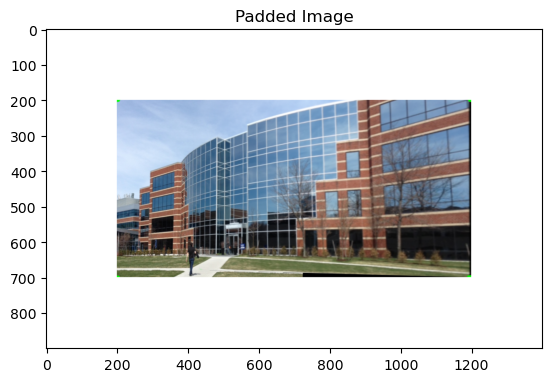

In [7]:
img = result3.copy()

top, bottom, left, right = 200,200,200,200
border_type = cv.BORDER_CONSTANT 
value = [255, 255, 255]  

img= cv.copyMakeBorder(img, top, bottom, left, right, border_type, value=value)
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
plt.title('Padded Image')
plt.show()


Selected points:
Point 1: [200. 198.]
Point 2: [1201.    2.]
Point 3: [1217.  898.]
Point 4: [201. 703.]
Homography Matrix:
[[ 2.09537642e+00 -4.14926023e-03 -4.18253730e+02]
 [ 2.31717480e-01  1.18341427e+00 -2.80659522e+02]
 [ 9.14447271e-04  1.69387603e-05  1.00000000e+00]]


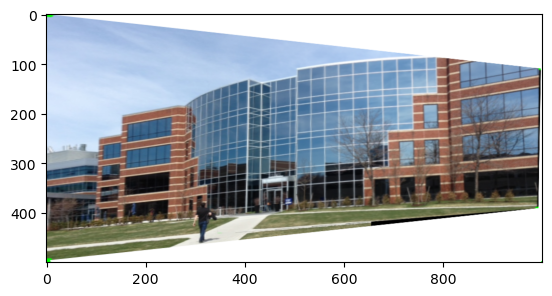

In [8]:
import cv2 as cv
import numpy as np

points = []
def select_points(event, x, y, flags, param):
    global points
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x, y])
        cv.circle(img, (x, y), 5, (0, 255, 0), -1)
        cv.imshow('image', img)

cv.namedWindow('image')
cv.setMouseCallback('image', select_points)
cv.imshow('image', img)
cv.waitKey(0)
cv.destroyAllWindows()

if len(points) != 4:
    raise ValueError("You must select exactly 4 points.")
points = np.array(points, dtype=np.float32)

print("Selected points:")
for i, point in enumerate(points):
    print(f"Point {i+1}: {point}")

width, height =1000,500
dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

M, _ = cv.findHomography(points, dst_points)
print("Homography Matrix:")
print(M)

result4 = cv.warpPerspective(img, M, (width, height))
plt.imshow(cv.cvtColor(result4,cv.COLOR_BGR2RGB))
plt.show()

(-0.5, 1999.5, 499.5, -0.5)

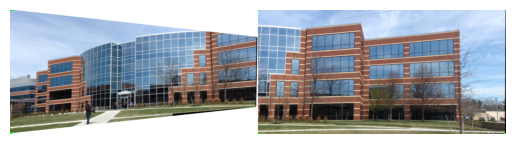

In [9]:
img12=result4.copy()
img34=result2.copy()

h1, w1 = img12.shape[:2]
h2, w2 = img34.shape[:2]
high=int(max(h1,h2))

img12 = cv.resize(img12, (w1, high))
img34 = cv.resize(img34 ,(w2, high))


concatenated_image = np.concatenate(( img12,img34), axis=1)
plt.imshow(cv.cvtColor(concatenated_image, cv.COLOR_BGR2RGB))
plt.axis('off')  

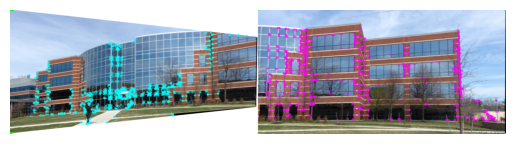

In [10]:
orb = cv.ORB_create(nfeatures=2000)
keypoints2, descriptors2 = orb.detectAndCompute(img12, None)
keypoints3, descriptors3 = orb.detectAndCompute(img34, None)
img2_kp = cv.drawKeypoints(img12, keypoints2, None, (255, 255, 0))
img3_kp = cv.drawKeypoints(img34, keypoints3, None, (255, 0, 255))
concatenated_image = np.concatenate(( img2_kp,img3_kp), axis=1)
plt.imshow(cv.cvtColor(concatenated_image, cv.COLOR_BGR2RGB))
plt.axis('off') 
plt.show()

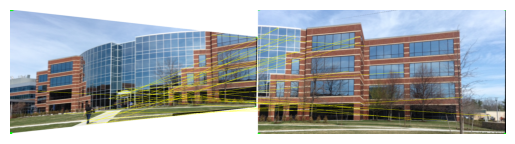

In [11]:
bf = cv.BFMatcher_create(cv.NORM_HAMMING)
matches23 = bf.knnMatch(descriptors2, descriptors3, k=2)
all_matches23 = []
for m, n in matches23:
  all_matches23.append(m)

img23= draw_matches(img12, keypoints2, img34, keypoints3, all_matches23[:30])
plt.imshow(cv.cvtColor(img23, cv.COLOR_BGR2RGB))
plt.axis('off')  # 关闭坐标轴
plt.show()

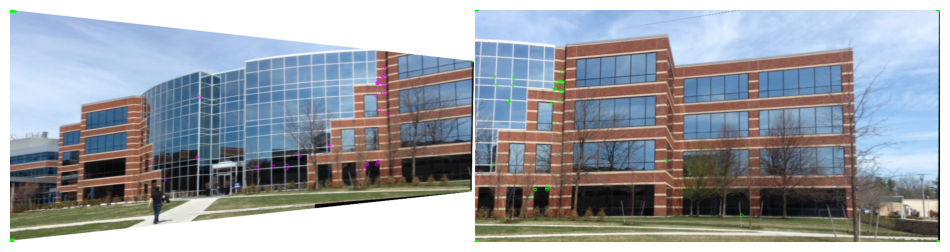

In [18]:
good23 = []
for m, n in matches23:
    if m.distance < 0.7 * n.distance:
        good23.append(m)

img2_kp = cv.drawKeypoints(img12, [keypoints2[m.queryIdx] for m in good23], None, (255, 0, 255))
img3_kp = cv.drawKeypoints(img34, [keypoints3[m.trainIdx] for m in good23], None, (0, 255, 0))
concatenated_image = np.concatenate(( img2_kp,img3_kp), axis=1)
plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(concatenated_image, cv.COLOR_BGR2RGB))

plt.axis('off')  
plt.show()


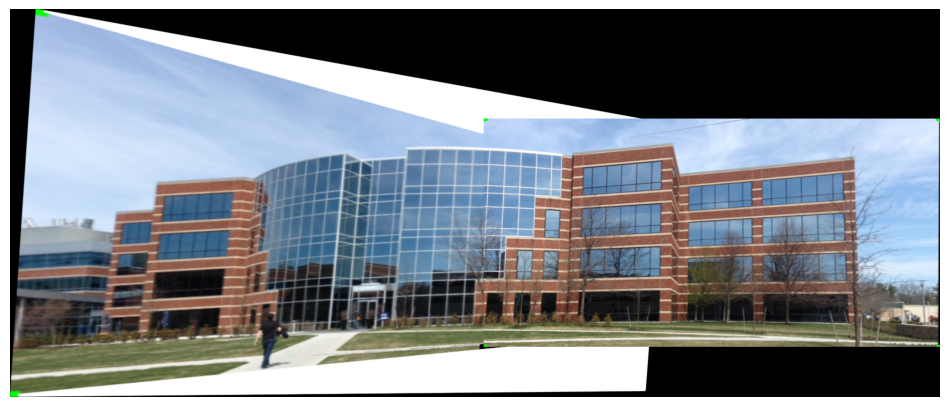

In [20]:
MIN_MATCH_COUNT = 10 # Set minimum match condition

if len(good23) > MIN_MATCH_COUNT:
    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([ keypoints2[m.queryIdx].pt for m in good23]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints3[m.trainIdx].pt for m in good23]).reshape(-1,1,2)

    # Вычисление матрицы гомографии
    M, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC,3)

    img23 = warpImages(img34, img12, M)
    plt.figure(figsize=(12, 6))

    plt.imshow(cv.cvtColor(img23, cv.COLOR_BGR2RGB))
    plt.axis('off')  # 关闭坐标轴
    plt.show()


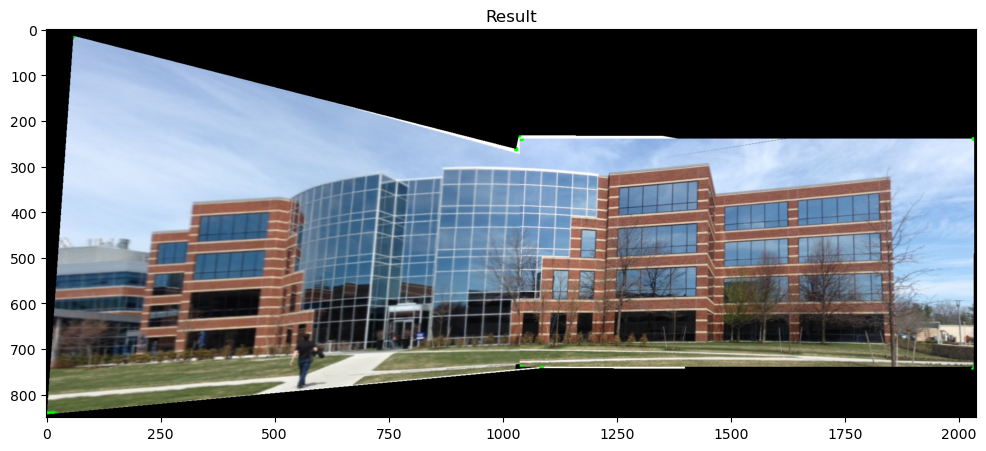

In [24]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


result = img23.copy()
points = []

def select_points(event, x, y, flags, param):
    global points
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x, y])
        cv.circle(result, (x, y), 5, (0, 255, 0), -1)
        cv.imshow('image', result)

cv.namedWindow('image')
cv.setMouseCallback('image', select_points)
cv.imshow('image', result)
cv.waitKey(0)
cv.destroyAllWindows()

if len(points) !=7:
    raise ValueError("You must select exactly 8 points.")
points = np.array(points, dtype=np.int32)

mask = np.zeros_like(result)
cv.fillPoly(mask, [points], (255, 255, 255))

if result.shape != mask.shape:
    raise ValueError("The dimensions of result and mask do not match.")

masked_image = cv.bitwise_and(result, mask)
plt.figure(figsize=(12, 6))

plt.imshow(cv.cvtColor(masked_image, cv.COLOR_BGR2RGB))
plt.title('Result')
plt.show()